In [1]:
import sys
!{sys.executable} -m pip install numpy;
!{sys.executable} -m pip install pandas;
!{sys.executable} -m pip install wfdb;
!{sys.executable} -m pip install matplotlib;
!{sys.executable} -m pip install scipy;
!{sys.executable} -m pip install sklearn;

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb
import torch
from scipy import signal
import torch.nn as nn

In [3]:
record = wfdb.rdheader('00001_lr')

In [4]:
#I II III aVR aVL aVF V1 V2 V3 V4 V5 V6
signals, fields = wfdb.rdsamp('00001_lr', channels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

In [5]:
leads = ["I", "II", "III", "aVL", "aVR", "aVF", "V1", "V2", "V3", "V4", "V5", "V6" ]
low_cutoff = 2.0
high_cutoff = 40.0
fs = 100.0

order = 1
nyquist = 0.5 * fs
low = low_cutoff / nyquist
high = high_cutoff / nyquist
b, a = signal.butter(order, [low, high], btype='band')

filtered = signal.lfilter(b, a, signals)

In [6]:
scaled = 2 * (filtered-np.min(filtered)) / (np.max(filtered)- np.min(filtered)) - 1

In [ ]:
for i in range(12):
    plt.figure(figsize=(20, 5))
    plt.plot(scaled[:, i], label=leads[i])
    plt.legend()
    plt.grid(True)
    plt.show()

In [17]:
learning_rate = 0.01
coefficient = torch.rand(1, requires_grad=True)
num_iterations = 10000

input_signal = torch.from_numpy(scaled[:,6])
actual = torch.from_numpy(scaled[:,7])

for i in range(num_iterations):
    predicted = input_signal*coefficient
    
    loss = nn.MSELoss()
    output = loss(predicted, actual)
    output.backward()
    
    with torch.no_grad():
        coefficient -= learning_rate * coefficient.grad
    
    coefficient.grad.zero_()

print("coefficient", coefficient.item())
upscaled_tensor = input_signal*coefficient
upscaled_noise = upscaled_tensor.detach().numpy()

order = 1
nyquist = 0.5 * fs
low = low_cutoff / nyquist
high = high_cutoff / nyquist
b, a = signal.butter(order, [low, high], btype='band')

upscaled = signal.lfilter(b, a, upscaled_noise)

coefficient 1.102510690689087


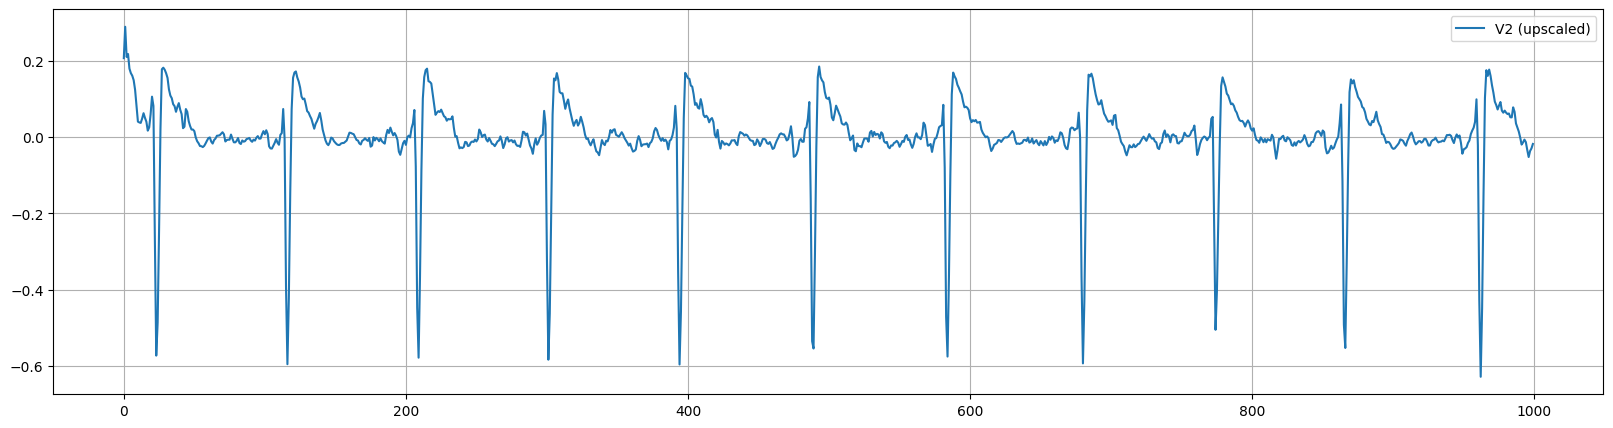

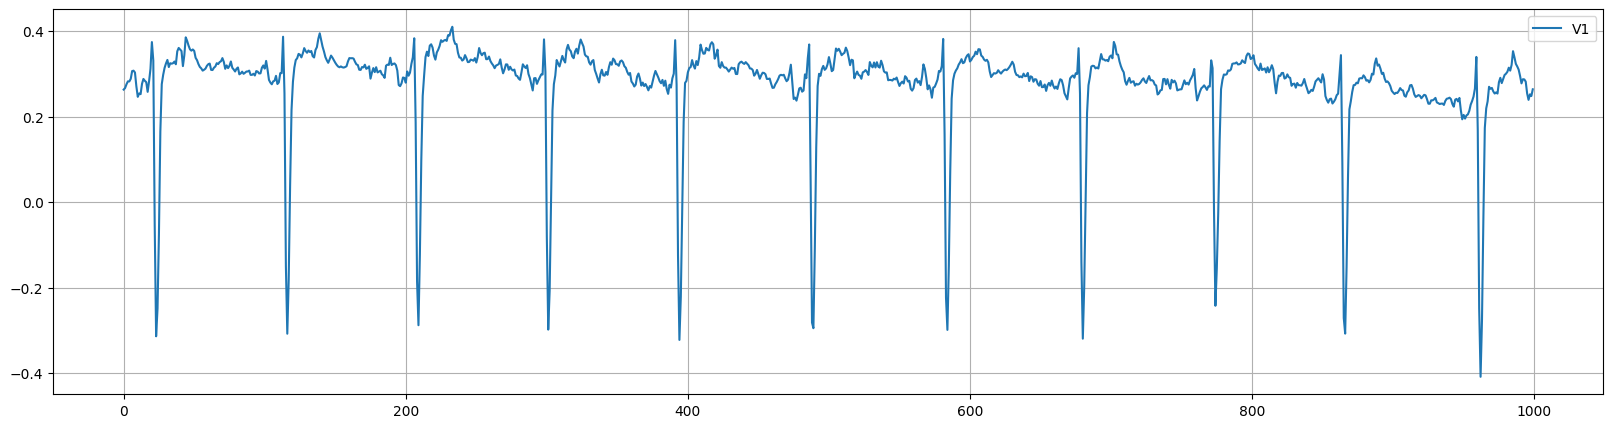

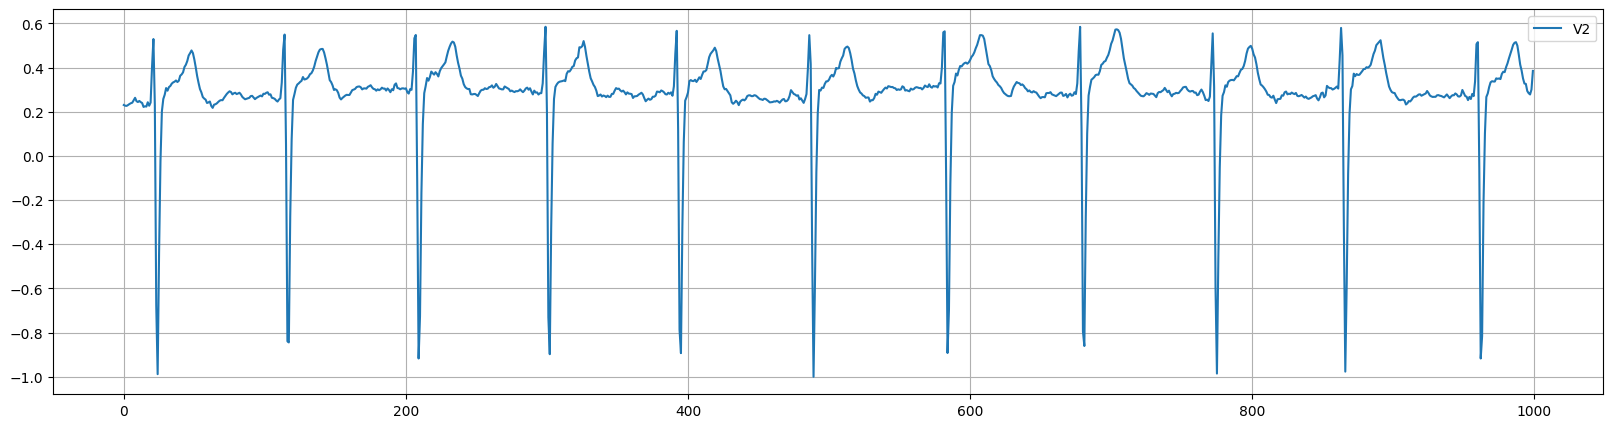

In [18]:
plt.figure(figsize=(20, 5))
plt.plot(upscaled, label="V2 (upscaled)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(scaled[:,6], label="V1")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 5))
plt.plot(scaled[:,7], label="V2")
plt.legend()
plt.grid(True)
plt.show()